In [1]:
import sys
import json
from os import listdir
from itertools import product
import importlib
import matplotlib.pyplot as plt
import numpy as np

import input_output
importlib.reload(input_output)
import inheritance_states
importlib.reload(inheritance_states)
import transition_matrices
importlib.reload(transition_matrices)
import genotypes
importlib.reload(genotypes)
import losses
importlib.reload(losses)
import viterbi
importlib.reload(viterbi)

<module 'viterbi' from '/Users/kelley/Projects/PhasingFamilies/phase/viterbi.py'>

In [9]:
# Read in command line arguments
chrom = '22'

data_dir = '../../DATA/mssng/genotypes'
ped_file = '../../DATA/mssng/mssng.ped.quads.ped'
param_file = '../params/mssng_quads_multiloss_params.json'
num_loss_regions = 2
assembly = '38'
max_af_cost = np.log10(2*71000/3)

#data_dir = '../../DATA/spark/genotypes'
#ped_file = '../../DATA/spark/spark.ped.quads.ped'
#param_file = '../params/spark_quads_multiloss_params.json'
#num_loss_regions = 1
#assembly = '38'

#data_dir = '../../DATA/ancestry/genotypes'
#ped_file = '../../DATA/ancestry/ancestry.ped'
#param_file = '../params/ancestry_multiloss_params.json'
#num_loss_regions = 1
#assembly = '37'

detect_deletions = False
detect_consanguinity = False

# set up filenames
sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, chrom)
coord_file = '%s/chr.%s.gen.coordinates.npy' % (data_dir,  chrom)
gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f])

with open(param_file, 'r') as f: 
    params = json.load(f)

In [10]:
#params['-log10(P[maternal_crossover])'] = 100
#params['-log10(P[paternal_crossover])'] = 100

In [11]:
# pull families of interest
families = input_output.pull_families(ped_file)

families pulled 806


In [12]:
print(families[0])

1-0059.1-0059-003A.1-0059-004


In [13]:
# make sure at least one individual has genetic data (chromosome 1 chosen arbitrarily)
sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, chrom)
with open(sample_file, 'r') as f:
	sample_ids = set([line.strip() for line in f])

for family in families:
	to_be_removed = [x for x in family.individuals if x not in sample_ids or (x not in params and '%s.%s' % (family.id, x) not in params)]
	family.prune(to_be_removed)
    
families = [x for x in families if x.num_descendents()>0]
print(len(families), 'have genomic data and parameters')

770 have genomic data and parameters


In [27]:
af_boundaries = np.arange(-np.log10(0.25), max_af_cost, np.log10(2)).tolist() # use rule of 3; we can't differentiate allele frequencies any smaller than 3/(2*num unrelated individuals).
af_boundaries.extend([-np.log10(1-(10.0**-x)) for x in af_boundaries[1:]])
af_boundaries = np.array(sorted(af_boundaries, reverse=True))
print(af_boundaries)


[4.51544993e+00 4.21441994e+00 3.91338994e+00 3.61235995e+00
 3.31132995e+00 3.01029996e+00 2.70926996e+00 2.40823997e+00
 2.10720997e+00 1.80617997e+00 1.50514998e+00 1.20411998e+00
 9.03089987e-01 6.02059991e-01 5.79919470e-02 2.80287236e-02
 1.37882845e-02 6.83942453e-03 3.40624869e-03 1.69978488e-03
 8.49060841e-04 4.24322928e-04 2.12109641e-04 1.06041871e-04
 5.30176991e-05 2.65080405e-05 1.32538180e-05]


In [28]:
# if we're detecting consanguinity, restrict to nuclear families
if detect_consanguinity:
    families = [x for x in families if x.num_ancestors()==2 and len(x.ordered_couples)==1]
    
    # to detect consanguinity, model a shared ancestor
    for family in families:
        family.add_child(family.mat_ancestors[0], 'mat_shared_ancestor', 'pat_shared_ancestor')
        family.add_child(family.pat_ancestors[0], 'mat_shared_ancestor', 'pat_shared_ancestor')
    
print(len(families))

770


In [29]:
import random


family = random.choice(families)
#family = [f for f in families if f.id=='SF0006106'][0]
#family = [f for f in families if f.id=='AU0364'][0]
print('family', family.id, family.individuals)
print(family.parents_to_children.items())

family AU3605.AU3605303.AU3605304 ['AU3605202', 'AU3605201', 'AU3605304', 'AU3605303']
dict_items([(('AU3605202', 'AU3605201'), ['AU3605304', 'AU3605303'])])


In [30]:
importlib.reload(inheritance_states)
importlib.reload(transition_matrices)

# create inheritance states
if chrom == 'X':
    states = inheritance_states.InheritanceStates(family, detect_deletions, True, num_loss_regions)
else:
    states = inheritance_states.InheritanceStates(family, detect_deletions, detect_deletions, num_loss_regions)

# create transition matrix
transitions = transition_matrices.TransitionMatrix(states, params)
                

fixed [('AU3605304', 'mat'), ('AU3605304', 'pat')]
inheritance states (8, 9)
transitions (8, 4)


In [31]:
importlib.reload(losses)

# create loss function
loss = losses.LazyLoss(states, family, params, num_loss_regions, af_boundaries)


no data []
AU3605202
	0/0	0/1	1/1	./.
0/0	0.0002-0.0007	3.8839-3.7422	5.7044-5.2236	3.5838-2.8785
0/1	2.4812-1.8080	0.0024-0.0094	2.9359-2.3900	3.0289-2.7734
1/1	3.3323-4.1023	3.7487-4.0070	0.0005-0.0009	3.2358-2.7162
-/0	0.0002-0.0007	3.8839-3.7422	5.7044-5.2236	3.5838-2.8785
-/1	3.3323-4.1023	3.7487-4.0070	0.0005-0.0009	3.2358-2.7162
-/-	3.7487-4.0070	4.5183-4.6629	3.8839-3.7422	0.0001-0.0001
AU3605201
	0/0	0/1	1/1	./.
0/0	0.0002-0.0007	3.8839-3.7422	5.6317-4.8315	3.4726-2.8181
0/1	2.4092-1.9710	0.0029-0.0078	2.8074-2.3761	2.9205-2.5396
1/1	3.8971-2.7325	3.7487-4.0070	0.0004-0.0017	3.1461-2.6976
-/0	0.0002-0.0007	3.8839-3.7422	5.6317-4.8315	3.4726-2.8181
-/1	3.8971-2.7325	3.7487-4.0070	0.0004-0.0017	3.1461-2.6976
-/-	3.7487-4.0070	4.7644-3.7820	3.8839-3.7422	0.0001-0.0002
AU3605304
	0/0	0/1	1/1	./.
0/0	0.0001-0.0004	4.0112-3.8128	5.9458-5.6401	3.6337-3.1036
0/1	2.6207-2.3455	0.0017-0.0044	3.0113-2.3830	3.2697-2.8184
1/1	4.6068-3.6620	3.8140-4.0089	0.0003-0.0004	3.2896-3.2185
-/0	0.00

In [32]:
#af_index = random.choice(np.arange(1, len(af_boundaries)))
#total_prob = np.zeros((states.num_states,))
#for gen in np.array(list(product(*([[0, 1, 2, -1]]*len(family)) + [[af_index]]))):
#    if np.all(gen[:-1]==0) or np.any(gen[:-1]>0):
#        total_prob += np.power(10, -loss(gen))
#        
#assert np.all(np.isclose(total_prob, 1))

In [33]:
import input_output
importlib.reload(input_output)

# pull genotype data for this family
family_genotypes, family_snp_positions, mult_factor = input_output.pull_gen_data_for_individuals(data_dir, af_boundaries, assembly, chrom, family.individuals)
print('Data pulled')



(4, 63698) (63698,)
genotypes pulled (5, 126154) [[ 0  2  0 ...  0  0  0]
 [ 0 -1  0 ...  0  1  0]
 [ 0 -1  0 ...  0  0  0]
 [ 0 -1  0 ...  0  1  0]
 [ 0 14  0 ...  0 13  0]]
Data pulled


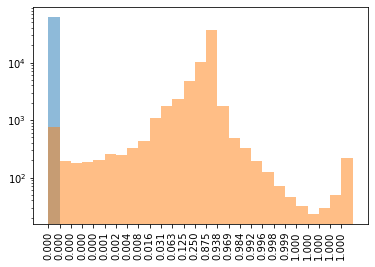

In [34]:
plt.hist(family_genotypes[-1, mult_factor==0], alpha=0.5, bins=np.arange(len(af_boundaries)+1), log=True)
plt.hist(family_genotypes[-1, (mult_factor>0) & ~np.all(family_genotypes[:-1, :]==0, axis=0)], alpha=0.5, bins=np.arange(len(af_boundaries)+1), log=True)
plt.hist(family_genotypes[-1, (mult_factor>0) & np.all(family_genotypes[:-1, :]==0, axis=0)], alpha=0.5, bins=np.arange(len(af_boundaries)+1), log=True)
plt.xticks(np.arange(len(af_boundaries)), ['%0.3f' % 10.0**-x for x in af_boundaries], rotation=90)
plt.show()

In [120]:
loss.set_cache(family_genotypes)


cached losses (32, 823) already_calculated 0


In [121]:
importlib.reload(viterbi)

# forward sweep
v_cost = viterbi.viterbi_forward_sweep(family_genotypes, family_snp_positions, mult_factor, states, transitions, loss)

# Forward sweep complete 30.899459838867188 sec
# Forward sweep complete 95.2498619556427 sec



Forward sweep complete 31.432731866836548 sec


In [122]:
importlib.reload(viterbi)

# backward sweep
final_states = viterbi.viterbi_backward_sweep(v_cost, states, transitions)

# Backward sweep complete 64.39986205101013 sec

#Num forks 1029
#Backward sweep complete 23.799263954162598 sec


Num solutions (1,) 283459.0319979846 (array([1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1], dtype=int8),)
Num forks 1328
Backward sweep complete 50.48164486885071 sec


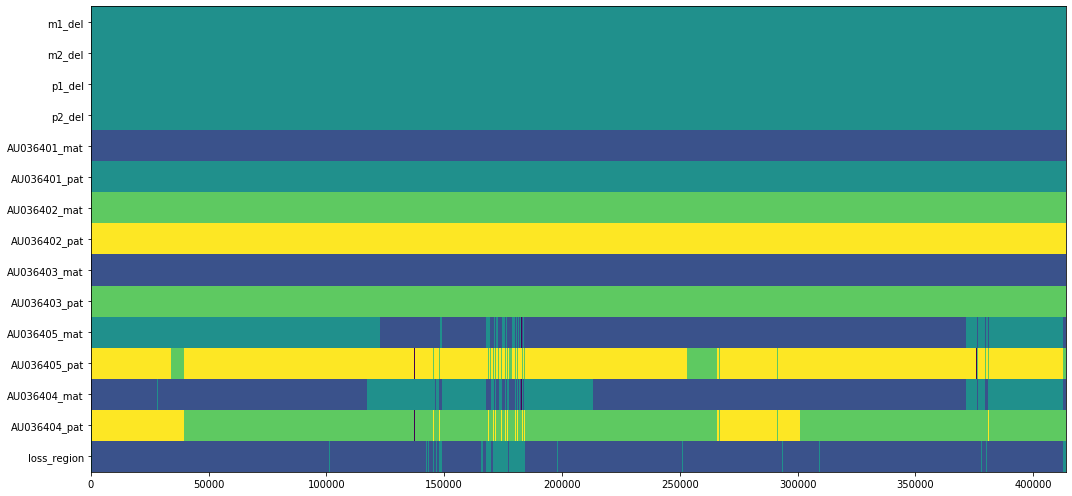

In [123]:
final_states_greyed = final_states.copy()
final_states_greyed[:, final_states[-1, :]==1] = -1

plt.figure(figsize=(15, 7))
plt.imshow(final_states, aspect='auto', vmin=-1)
plt.yticks(np.arange(final_states.shape[0]), 
           ['m%d_del' % i for i in range(1, 2*len(family.mat_ancestors)+1)] + ['p%d_del' % i for i in range(1, 2*len(family.pat_ancestors)+1)] + \
           sum([['%s_mat' % x,'%s_pat' % x] for x in family.individuals], []) + ['loss_region'])

#plt.subplot(2, 1, 2, sharex=ax)
#plt.fill_between(np.arange(family_snp_positions.shape[0]), 0, (family_snp_positions[:, 0]>=0) & (family_snp_positions[:, 1]<=20500000), alpha=0.5)
#plt.fill_between(np.arange(family_snp_positions.shape[0]), 0, (family_snp_positions[:, 0]>=9600000) & (family_snp_positions[:, 1]<=16300000))
#plt.fill_between(np.arange(family_snp_positions.shape[0]), 0, (family_snp_positions[:, 1]<=9600000) | (family_snp_positions[:, 0]>=48200000))

#plt.xticks(xticks, xlabels, rotation=90)

#plt.subplot(3, 1, 3)
#plt.plot(np.log2(family_snp_positions[:, 1]-family_snp_positions[:, 0]), marker='.', linestyle='')
#plt.plot(c[1:]-c[:-1], marker='.', linestyle='')
#plt.plot(num_non_mend, marker='.', linestyle='')
#plt.plot(np.convolve(num_non_mend, np.ones((100,)), mode='same'))
#plt.plot(np.convolve(num_missing, np.ones((100,)), mode='same'))
#plt.scatter(family_snp_positions[:, 0], final_states[-1, :], marker='.')
#plt.xticks(family_snp_positions[xticks, 0], xlabels, rotation=90)
#for i in np.where(family_snp_positions[:, 1]-family_snp_positions[:, 0] > 10000)[0]:
#    plt.plot([family_snp_positions[i, 0], family_snp_positions[i, 1]], [final_states[-1, i], final_states[-1, i]], color='grey')
#    #print(family_snp_positions[i, :])
plt.tight_layout()
plt.show()

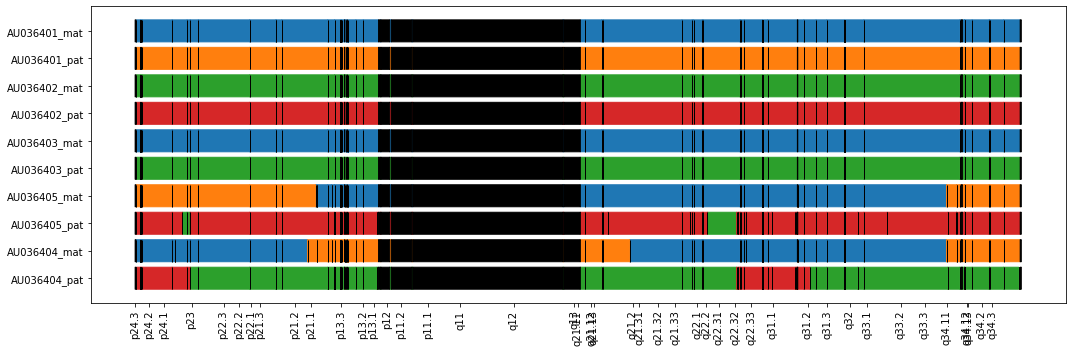

In [128]:
cyto = []
with open('../data/cytoBand%s.txt' % assembly, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[0] == 'chr%s'%chrom:
            cyto.append((int(pieces[1]), int(pieces[2]), pieces[3]))
            
            prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors[-1] = 'black'

indices = np.arange(2*family.num_ancestors(), final_states.shape[0]-1)

plt.figure(figsize=(15, 5))
for i, j in enumerate(indices):    
    a = np.zeros((2*final_states.shape[1],), dtype=int)
    b = np.zeros((2*final_states.shape[1],), dtype=float)
    a[0::2] = family_snp_positions[:, 0]
    a[1::2] = family_snp_positions[:, 1]
    b[0::2] = final_states_greyed[j, :]
    b[1::2] = final_states_greyed[j, :]

    for m in [0, 1, 2, 3, -1]:
        c = np.zeros((a.shape[0],), dtype=float)
        c[b==m] = -i
        c[b!=m] = np.nan
        plt.fill_between(a, c-0.4, c+0.4, color=colors[m])
plt.yticks(np.arange(0, -len(indices), -1), sum([['%s_mat' % x,'%s_pat' % x] for x in family.individuals], []))
plt.xticks([x[0] for x in cyto], [x[2] for x in cyto], rotation=90)

#plt.xlim([1, 1000000])
plt.tight_layout()
plt.show()

In [129]:
np.sum((final_states[-1, :]==0)*mult_factor)/np.sum(mult_factor)


0.9616622484584835

In [126]:
print(np.sum((final_states[10, :400000]==0) & (final_states[-1, :400000]!=1)))

228557


In [127]:
print(np.sum((final_states[10, :]==0)*mult_factor)/np.sum(mult_factor))
print(np.sum((final_states[11, :]==2)*mult_factor)/np.sum(mult_factor))


0.5774360794654972
0.058393524935448686


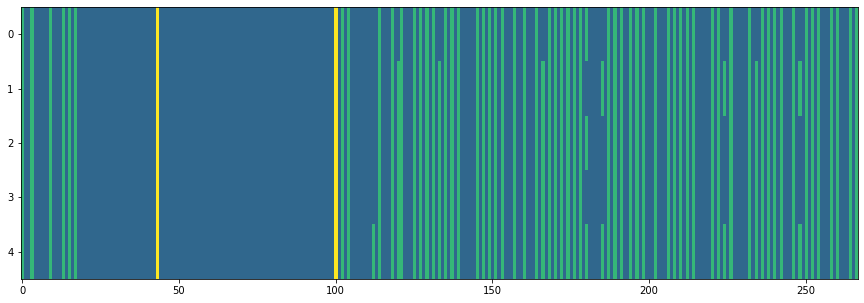

In [1206]:
plt.figure(figsize=(15, 5))
indices = (final_states[10, :400000]==0) & (final_states[-1, :400000]!=1)
plt.imshow(family_genotypes[:, :400000][:-1, indices], aspect='auto', vmin=-1, vmax=2)
plt.show()